In [40]:
import numpy as np
import pandas as pd

from causalnex.discretiser import Discretiser
from causalnex.network import BayesianNetwork
from causalnex.structure import StructureModel
from causalnex.structure.notears import from_pandas
from causalnex.plots import plot_structure

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


In [2]:
sm = StructureModel()
sm.add_edges_from([
    ('health', 'absences'),
    ('health', 'G1')
])


In [3]:
sm.edges

OutEdgeView([('health', 'absences'), ('health', 'G1')])

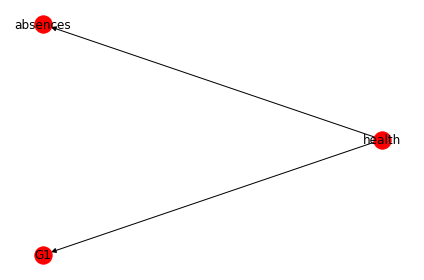

In [5]:
_, _, _ = plot_structure(sm);


In [6]:
data = pd.read_csv('https://raw.githubusercontent.com/martin-fabbri/colab-notebooks/master/data/causal-inference/student-por.csv', delimiter=';')
data.head(5)

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [7]:
drop_col = ['school', 'sex', 'age', 'Mjob', 'Fjob', 'reason', 'guardian']
data = data.drop(columns=drop_col)
data.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,U,GT3,A,4,4,2,2,0,yes,no,...,4,3,4,1,1,3,4,0,11,11
1,U,GT3,T,1,1,1,2,0,no,yes,...,5,3,3,1,1,3,2,9,11,11
2,U,LE3,T,1,1,1,2,0,yes,no,...,4,3,2,2,3,3,6,12,13,12
3,U,GT3,T,4,2,1,3,0,no,yes,...,3,2,2,1,1,5,0,14,14,14
4,U,GT3,T,3,3,1,2,0,no,yes,...,4,3,2,1,2,5,0,11,13,13


In [8]:
struct_data = data.copy()
non_numeric_columns = list(struct_data.select_dtypes(exclude=[np.number]).columns)
non_numeric_columns

['address',
 'famsize',
 'Pstatus',
 'schoolsup',
 'famsup',
 'paid',
 'activities',
 'nursery',
 'higher',
 'internet',
 'romantic']

In [10]:
le = LabelEncoder()
for col in non_numeric_columns:
    struct_data[col] = le.fit_transform(struct_data[col])
struct_data.head(5)

,address,famsize,Pstatus,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,1,0,0,4,4,2,2,0,1,0,...,4,3,4,1,1,3,4,0,11,11
1,1,0,1,1,1,1,2,0,0,1,...,5,3,3,1,1,3,2,9,11,11
2,1,1,1,1,1,1,2,0,1,0,...,4,3,2,2,3,3,6,12,13,12
3,1,0,1,4,2,1,3,0,0,1,...,3,2,2,1,1,5,0,14,14,14
4,1,0,1,3,3,1,2,0,0,1,...,4,3,2,1,2,5,0,11,13,13


C:\ProgramData\Anaconda3\envs\causalnex\lib\site-packages\networkx\drawing\nx_pylab.py:563: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
C:\ProgramData\Anaconda3\envs\causalnex\lib\site-packages\networkx\drawing\nx_pylab.py:660: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


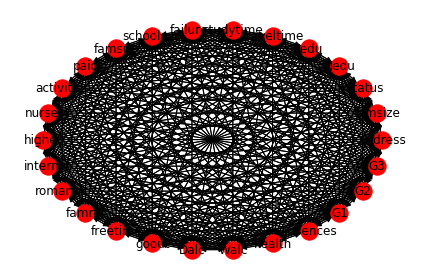

In [12]:
sm = from_pandas(struct_data)
_, _, _ = plot_structure(sm)

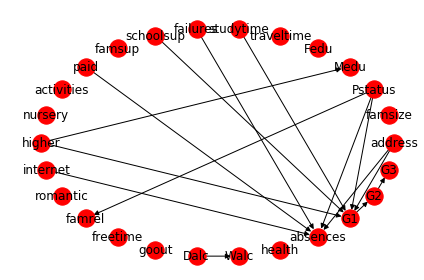

In [13]:
sm.remove_edges_below_threshold(0.8)
_, _, _ = plot_structure(sm)

In [14]:
sm.add_edge('failures', 'G1')
sm.remove_edge('Pstatus', 'G1')
sm.remove_edge('address', 'G1')

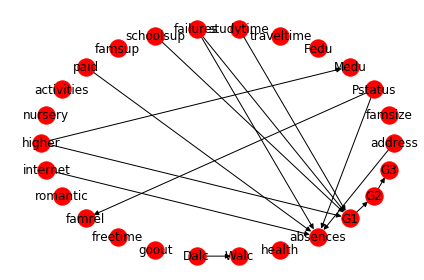

In [15]:
_, _, _ = plot_structure(sm)

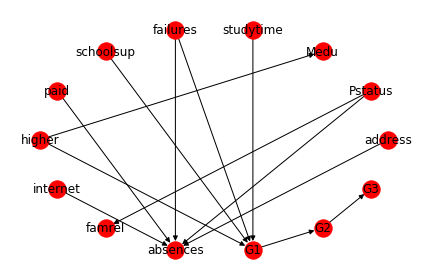

In [17]:
sm = sm.get_largest_subgraph()
_, _, _ = plot_structure(sm)

In [21]:
bn = BayesianNetwork(sm)

In [30]:
data_vals = {col: data[col].unique() for col in data.columns}

failures_map = {v: 'no-failure' if v == [0] else 'have-failure' for v in data_vals['failures']}

studytime_map = {v: 'short-studytime' if v in [1, 2] else 'long-studytime' for v in data_vals['studytime']}

In [37]:
discretised_data = data.copy()
discretised_data['absences'] = Discretiser(method='fixed', numeric_split_points=[1, 10]).transform(discretised_data['absences'].values)
discretised_data['G1'] = Discretiser(method='fixed', numeric_split_points=[10]).transform(discretised_data['G1'].values)
discretised_data['G2'] = Discretiser(method='fixed', numeric_split_points=[10]).transform(discretised_data['G2'].values)
discretised_data['G3'] = Discretiser(method='fixed', numeric_split_points=[10]).transform(discretised_data['G3'].values)

In [38]:
absences_map = {0: "No-absence", 1: "Low-absence", 2: "High-absence"}

G1_map = {0: "Fail", 1: "Pass"}
G2_map = {0: "Fail", 1: "Pass"}
G3_map = {0: "Fail", 1: "Pass"}

discretised_data["absences"] = discretised_data["absences"].map(absences_map)
discretised_data["G1"] = discretised_data["G1"].map(G1_map)
discretised_data["G2"] = discretised_data["G2"].map(G2_map)
discretised_data["G3"] = discretised_data["G3"].map(G3_map)

In [48]:
train, test = train_test_split(discretised_data, train_size=0.9, test_size=0.1, random_state=7)

In [50]:
bn = bn.fit_node_states(discretised_data)

In [52]:
bn = bn.fit_cpds(train, method='BayesianEstimator',  bayes_prior='K2')

C:\ProgramData\Anaconda3\envs\causalnex\lib\site-packages\pandas\core\generic.py:5069: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  object.__getattribute__(self, name)
C:\ProgramData\Anaconda3\envs\causalnex\lib\site-packages\pandas\core\generic.py:5070: FutureWarning: Attribute 'is_copy' is deprecated and will be removed in a future version.
  return object.__setattr__(self, name, value)


In [53]:
bn.cpds['G1']

failures          0                                                    \
higher           no                                               yes   
schoolsup        no                      yes                       no   
studytime         1         2    3    4    1    2    3    4         1   
G1                                                                      
Fail       0.571429  0.666667  0.5  0.5  0.5  0.5  0.5  0.5  0.181818   
Pass       0.428571  0.333333  0.5  0.5  0.5  0.5  0.5  0.5  0.818182   

failures             ...    3                                               \
higher               ...   no            yes                                 
schoolsup            ...  yes             no                 yes             
studytime         2  ...    3    4         1    2    3    4    1         2   
G1                   ...                                                     
Fail       0.134021  ...  0.5  0.5  0.666667  0.5  0.5  0.5  0.5  0.666667   
Pass       0.865979  ...  0.5  0.5  0.333333  0.5  0.5  0.5  0.5  0.333333   

failures             
higher               
schoolsup            
studytime    3    4  
G1                   
Fail       0.5  0.5  
Pass       0.5  0.5  

[2 rows x 64 columns]

In [54]:
discretised_data.loc[18, discretised_data.columns != 'G1']

address                 U
famsize               GT3
Pstatus                 T
Medu                    3
Fedu                    2
traveltime              1
studytime               1
failures                3
schoolsup              no
famsup                yes
paid                  yes
activities            yes
nursery               yes
higher                yes
internet              yes
romantic               no
famrel                  5
freetime                5
goout                   5
Dalc                    2
Walc                    4
health                  5
absences      Low-absence
G2                   Fail
G3                   Fail
Name: 18, dtype: object

In [55]:
predictions = bn.predict(discretised_data, 'G1')

In [56]:
print('The prediction is \'{prediction}\''.format(prediction=predictions.loc[18, 'G1_prediction']))

The prediction is 'Fail'


In [57]:
from causalnex.evaluation import classification_report
classification_report(bn, test, "G1")

,precision,recall,f1-score,support
G1_Fail,0.700000,0.583333,0.636364,12
G1_Pass,0.909091,0.943396,0.925926,53
macro avg,0.804545,0.763365,0.781145,65
micro avg,0.876923,0.876923,0.876923,65
weighted avg,0.870490,0.876923,0.872468,65


In [58]:
from causalnex.evaluation import roc_auc
roc, auc = roc_auc(bn, test, "G1")
print(auc)

0.9253254437869822


In [59]:
bn = bn.fit_cpds(discretised_data, method="BayesianEstimator", bayes_prior="K2")

In [61]:
from causalnex.inference import InferenceEngine

ie = InferenceEngine(bn)
marginals = ie.query()
marginals["G1"]

{'Fail': 0.25335423043447797, 'Pass': 0.746645769565522}

In [62]:
marginals_short = ie.query({"studytime": "short-studytime"})
marginals_long = ie.query({"studytime": "long-studytime"})
print("Marginal G1 | Short Studtyime", marginals_short["G1"])
print("Marginal G1 | Long Studytime", marginals_long["G1"])

VariableValueNotInDomainError: studytime=short-studytime